In [1]:
import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

Using K-means clustering

[*********************100%***********************]  30 of 30 completed


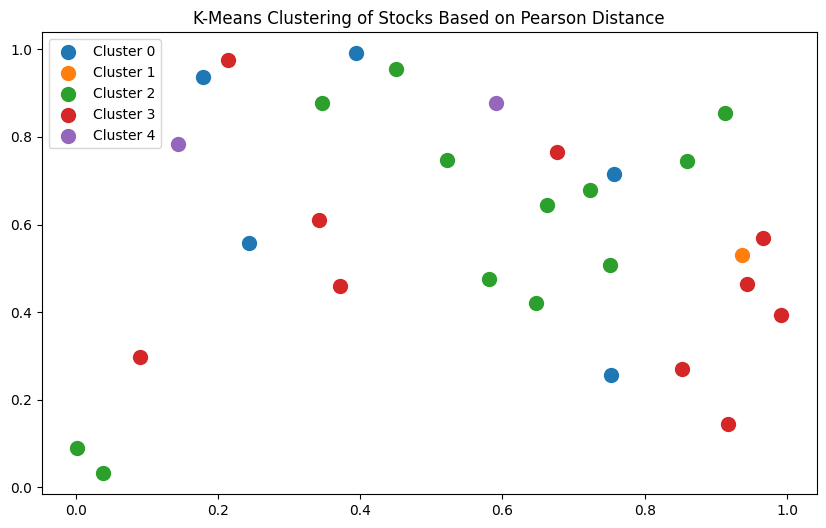

Best Cointegrated Pairs:
Stock 1: BABA, Stock 2: V, p-value: 0.00000
Stock 1: BA, Stock 2: CVX, p-value: 0.00000
Stock 1: AAPL, Stock 2: GOOGL, p-value: 0.00000
Stock 1: MSFT, Stock 2: MA, p-value: 0.00000
Stock 1: AMZN, Stock 2: NFLX, p-value: 0.00000
Stock 1: NVDA, Stock 2: INTC, p-value: 0.00000
Stock 1: IBM, Stock 2: PEP, p-value: 0.00000
Stock 1: AMD, Stock 2: COST, p-value: 0.00000
Stock 1: TSLA, Stock 2: JPM, p-value: 0.00000
Stock 1: PYPL, Stock 2: CSCO, p-value: 0.00000
Stock 1: ADBE, Stock 2: WMT, p-value: 0.00000
Stock 1: DIS, Stock 2: NKE, p-value: 0.00000
Stock 1: PG, Stock 2: KO, p-value: 0.00000
Stock 1: META, Stock 2: XOM, p-value: 0.00000


In [2]:


import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

def pearson_distance(a, b):
    """Calculate Pearson distance between two series."""
    return 1 - np.corrcoef(a, b)[0, 1]

def apply_cointegration_test(cluster_stocks, returns):
    """Apply cointegration tests to find cointegrated pairs within a cluster."""
    cointegrated_pairs = []
    for i in range(len(cluster_stocks)):
        for j in range(i + 1, len(cluster_stocks)):
            stock1 = cluster_stocks[i]
            stock2 = cluster_stocks[j]
            score, p_value, _ = coint(returns[stock1], returns[stock2])
            # If p-value < 0.05, we consider the pair cointegrated
            cointegrated_pairs.append((stock1, stock2, p_value))
    return cointegrated_pairs

def kmeans_with_cointegration(tickers, start_date, end_date, n_clusters=5):
    """
    Fetch historical stock data, cluster stocks using K-Means with Pearson distance,
    and apply cointegration tests within each cluster to find pairs for pairs trading.

    Parameters:
    tickers (list): List of stock tickers to analyze.
    start_date (str): Start date for historical data.
    end_date (str): End date for historical data.
    n_clusters (int): Number of clusters for K-Means.

    Returns:
    final_pairs (list): List of tuples containing the best cointegrated pairs of stocks.
    """

    # Download stock data
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

    # Calculate daily percentage returns and drop NaN values
    returns = data.pct_change().dropna()

    # Check for any remaining NaN values
    returns = returns.dropna(axis=1, how='any')

    # Compute Pearson distance matrix
    distance_matrix = pdist(returns.T, metric=lambda u, v: pearson_distance(u, v))

    # Convert distance matrix to square form
    distance_matrix_square = squareform(distance_matrix)

    # Apply K-Means clustering on Pearson distance matrix using a precomputed distance method
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    # Fit KMeans clustering using Pearson distance
    kmeans.fit(distance_matrix_square)

    # Add the cluster labels to the DataFrame
    cluster_labels = kmeans.labels_

    # Assign clusters to tickers
    cluster_df = pd.DataFrame({'Ticker': tickers, 'Cluster': cluster_labels})

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    for i in range(n_clusters):
        cluster_stocks = cluster_df[cluster_df['Cluster'] == i]['Ticker']
        plt.scatter(np.random.rand(len(cluster_stocks)), np.random.rand(len(cluster_stocks)), label=f'Cluster {i}', s=100)

    plt.title('K-Means Clustering of Stocks Based on Pearson Distance')
    plt.legend()
    plt.show()

    # Apply cointegration tests within each cluster and choose the best pair per stock
    final_pairs = []
    used_stocks = set()  # To keep track of stocks already paired

    for cluster_num in range(n_clusters):
        cluster_stocks = cluster_df[cluster_df['Cluster'] == cluster_num]['Ticker'].tolist()

        # Get all cointegrated pairs in the current cluster
        cointegrated_pairs = apply_cointegration_test(cluster_stocks, returns)

        # Sort pairs by p-value (best cointegration comes first)
        cointegrated_pairs.sort(key=lambda x: x[2])

        for stock1, stock2, p_value in cointegrated_pairs:
            # Only pair stocks that haven't been paired yet
            if stock1 not in used_stocks and stock2 not in used_stocks:
                final_pairs.append((stock1, stock2, p_value))
                used_stocks.add(stock1)
                used_stocks.add(stock2)

    return final_pairs

# Example usage with a larger number of stocks, replaced 'FB' with 'META'
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 'BABA', 'JPM',
           'V', 'MA', 'PYPL', 'INTC', 'CSCO', 'ADBE', 'ORCL', 'IBM', 'AMD', 'CRM',
           'BA', 'COST', 'WMT', 'PG', 'KO', 'PEP', 'XOM', 'CVX', 'DIS', 'NKE']

# Get pairs of stocks based on Pearson clustering and cointegration
pairs = kmeans_with_cointegration(tickers, start_date="2020-01-01", end_date="2023-01-01", n_clusters=5)

# Print cointegrated pairs
print("Best Cointegrated Pairs:")
for pair in pairs:
    print(f"Stock 1: {pair[0]}, Stock 2: {pair[1]}, p-value: {pair[2]:.5f}")


Hierarchial Clustering using Pearson Distance approach

[*********************100%***********************]  30 of 30 completed


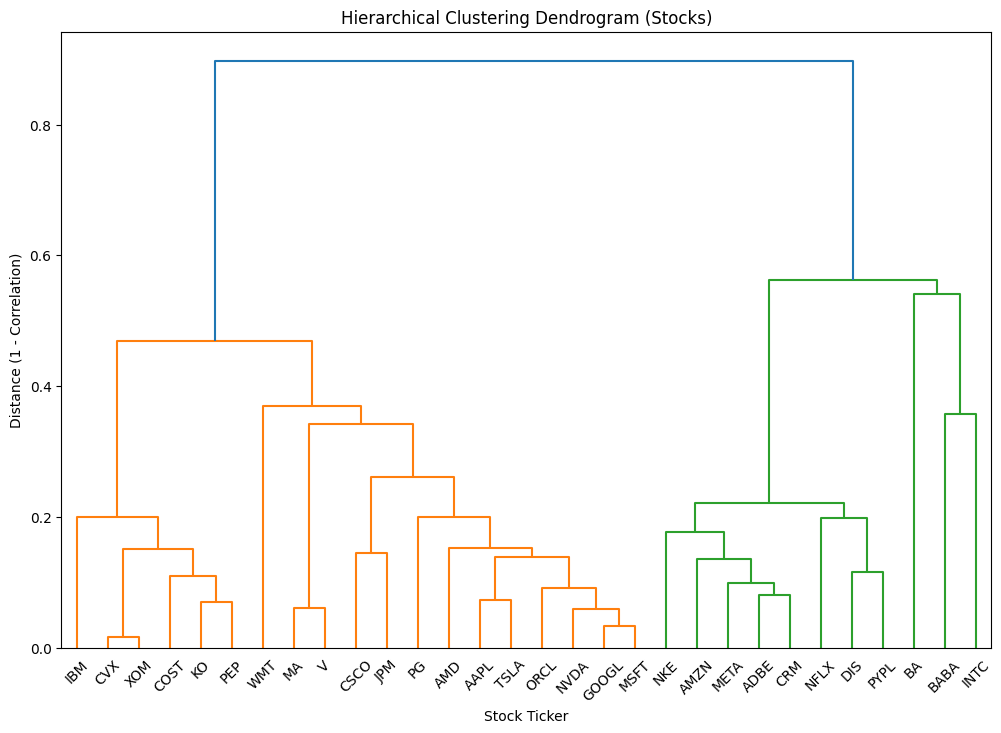

Best Cointegrated Pairs:
Stock 1: IBM, Stock 2: XOM, p-value: 0.00714
Stock 1: CSCO, Stock 2: GOOGL, p-value: 0.03872
Stock 1: ADBE, Stock 2: CRM, p-value: 0.04633


In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

def pearson_distance(u, v):
    """Calculate Pearson distance between two series."""
    return 1 - np.corrcoef(u, v)[0, 1]

def hierarchical_clustering_with_cointegration(tickers, start_date, end_date, distance_threshold=0.3):
    """
    Fetch historical stock data, perform hierarchical clustering using Pearson distance,
    and apply cointegration tests within each cluster to find pairs for pairs trading.

    Parameters:
    tickers (list): List of stock tickers to analyze.
    start_date (str): Start date for historical data.
    end_date (str): End date for historical data.
    distance_threshold (float): Threshold for forming flat clusters.

    Returns:
    final_pairs (list): List of tuples containing the best cointegrated pairs of stocks.
    """

    # Download stock data
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

    # Drop any columns with missing data
    data = data.dropna(axis=1, how='any')
    tickers = data.columns.tolist()  # Update tickers list based on available data

    # Transpose data for clustering
    data_transposed = data.T

    # Compute the Pearson distance matrix
    distance_matrix = pdist(data_transposed, metric=pearson_distance)

    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='average')

    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=data_transposed.index)
    plt.title('Hierarchical Clustering Dendrogram (Stocks)')
    plt.xlabel('Stock Ticker')
    plt.ylabel('Distance (1 - Correlation)')
    plt.show()

    # Form clusters based on the distance threshold
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

    # Assign cluster labels to stocks
    cluster_df = pd.DataFrame({'Ticker': data_transposed.index, 'Cluster': cluster_labels})

    # Apply cointegration tests within each cluster
    final_pairs = []
    used_stocks = set()

    for cluster_num in np.unique(cluster_labels):
        cluster_stocks = cluster_df[cluster_df['Cluster'] == cluster_num]['Ticker'].tolist()

        if len(cluster_stocks) < 2:
            continue  # Need at least two stocks to form a pair

        # Get all possible pairs
        pairs_in_cluster = []
        for i in range(len(cluster_stocks)):
            for j in range(i + 1, len(cluster_stocks)):
                stock1 = cluster_stocks[i]
                stock2 = cluster_stocks[j]
                # Apply cointegration test on price series
                try:
                    score, p_value, _ = coint(data[stock1], data[stock2])
                    if p_value < 0.05 and not np.isnan(p_value):
                        pairs_in_cluster.append((stock1, stock2, p_value))
                except Exception as e:
                    print(f"Error testing pair {stock1} and {stock2}: {e}")

        # Sort pairs by p-value (best cointegration comes first)
        pairs_in_cluster.sort(key=lambda x: x[2])

        for stock1, stock2, p_value in pairs_in_cluster:
            if stock1 not in used_stocks and stock2 not in used_stocks:
                final_pairs.append((stock1, stock2, p_value))
                used_stocks.update([stock1, stock2])

    return final_pairs

# Example usage
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 'BABA', 'JPM',
           'V', 'MA', 'PYPL', 'INTC', 'CSCO', 'ADBE', 'ORCL', 'IBM', 'AMD', 'CRM',
           'BA', 'COST', 'WMT', 'PG', 'KO', 'PEP', 'XOM', 'CVX', 'DIS', 'NKE']

pairs = hierarchical_clustering_with_cointegration(tickers, start_date="2020-01-01", end_date="2023-01-01", distance_threshold=0.3)

print("Best Cointegrated Pairs:")
for pair in pairs:
    print(f"Stock 1: {pair[0]}, Stock 2: {pair[1]}, p-value: {pair[2]:.5f}")


[*********************100%***********************]  30 of 30 completed


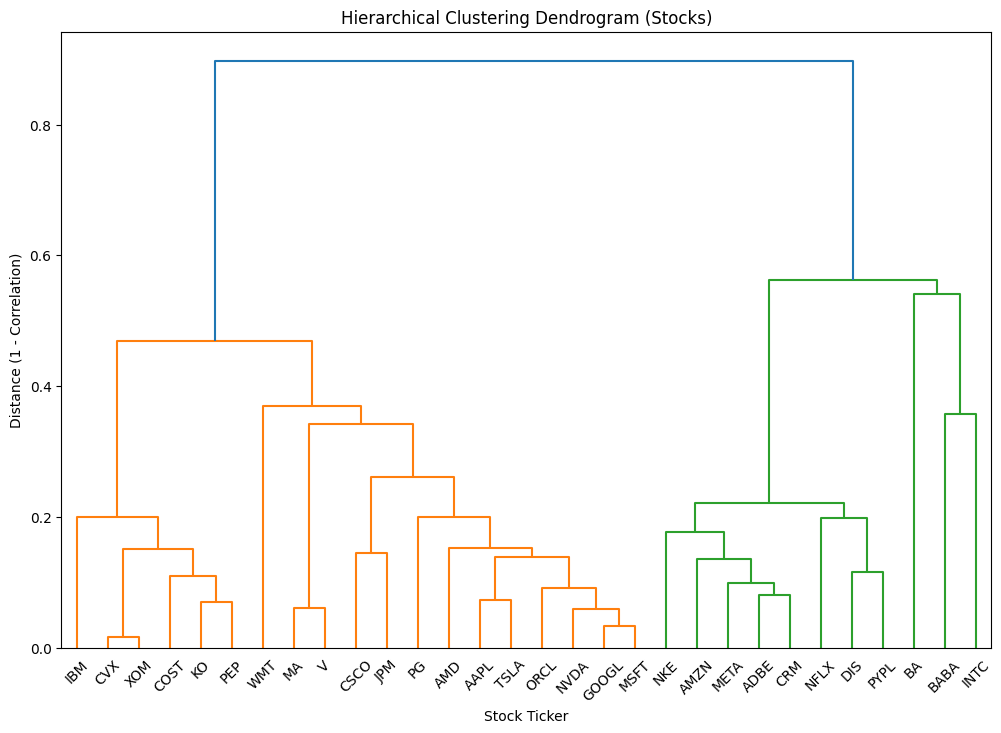

Cointegrated Pairs:
Stock 1: IBM, Stock 2: XOM, p-value: 0.00714
Stock 1: MA, Stock 2: WMT, p-value: 0.01262
Stock 1: MA, Stock 2: PG, p-value: 0.01780
Stock 1: IBM, Stock 2: KO, p-value: 0.02056
Stock 1: MA, Stock 2: MSFT, p-value: 0.02746
Stock 1: V, Stock 2: WMT, p-value: 0.02825
Stock 1: IBM, Stock 2: PEP, p-value: 0.03265
Stock 1: CSCO, Stock 2: GOOGL, p-value: 0.03872
Stock 1: MA, Stock 2: NVDA, p-value: 0.04239
Stock 1: PEP, Stock 2: XOM, p-value: 0.04340
Stock 1: CSCO, Stock 2: NVDA, p-value: 0.04455
Stock 1: CSCO, Stock 2: ORCL, p-value: 0.06440
Stock 1: CVX, Stock 2: PEP, p-value: 0.06534
Stock 1: COST, Stock 2: KO, p-value: 0.06643
Stock 1: JPM, Stock 2: V, p-value: 0.06689
Stock 1: CSCO, Stock 2: MSFT, p-value: 0.06751
Stock 1: KO, Stock 2: XOM, p-value: 0.06780
Stock 1: MA, Stock 2: TSLA, p-value: 0.07439
Stock 1: MSFT, Stock 2: ORCL, p-value: 0.07495
Stock 1: MSFT, Stock 2: NVDA, p-value: 0.08307
Stock 1: CVX, Stock 2: XOM, p-value: 0.08719
Stock 1: MA, Stock 2: ORCL, p-v

In [14]:
##Try to match every stock with every pair and calculate p-value to see how good it is

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

def pearson_distance(u, v):
    """Calculate Pearson distance between two series."""
    return 1 - np.corrcoef(u, v)[0, 1]

def hierarchical_clustering_with_cointegration(tickers, start_date, end_date, distance_threshold=0.6, p_value_threshold=0.1):
    """
    Fetch historical stock data, perform hierarchical clustering using Pearson distance,
    and apply cointegration tests within each cluster to find pairs for pairs trading.

    Parameters:
    tickers (list): List of stock tickers to analyze.
    start_date (str): Start date for historical data.
    end_date (str): End date for historical data.
    distance_threshold (float): Threshold for forming flat clusters.
    p_value_threshold (float): Maximum p-value for considering a pair as cointegrated.

    Returns:
    final_pairs (list): List of tuples containing cointegrated pairs of stocks.
    """

    # Download stock data
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

    # Drop any columns with missing data
    data = data.dropna(axis=1, how='any')
    tickers = data.columns.tolist()  # Update tickers list based on available data

    # Transpose data for clustering
    data_transposed = data.T

    # Compute the Pearson distance matrix
    distance_matrix = pdist(data_transposed, metric=pearson_distance)

    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='average')

    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=data_transposed.index)
    plt.title('Hierarchical Clustering Dendrogram (Stocks)')
    plt.xlabel('Stock Ticker')
    plt.ylabel('Distance (1 - Correlation)')
    plt.show()

    # Form clusters based on the distance threshold
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

    # Assign cluster labels to stocks
    cluster_df = pd.DataFrame({'Ticker': data_transposed.index, 'Cluster': cluster_labels})

    # Apply cointegration tests within each cluster
    final_pairs = []

    for cluster_num in np.unique(cluster_labels):
        cluster_stocks = cluster_df[cluster_df['Cluster'] == cluster_num]['Ticker'].tolist()

        if len(cluster_stocks) < 2:
            continue  # Need at least two stocks to form a pair

        # Get all possible pairs
        pairs_in_cluster = []
        for i in range(len(cluster_stocks)):
            for j in range(i + 1, len(cluster_stocks)):
                stock1 = cluster_stocks[i]
                stock2 = cluster_stocks[j]
                # Apply cointegration test on price series
                try:
                    score, p_value, _ = coint(data[stock1], data[stock2])
                    if p_value < p_value_threshold and not np.isnan(p_value):
                        pairs_in_cluster.append((stock1, stock2, p_value))
                except Exception as e:
                    print(f"Error testing pair {stock1} and {stock2}: {e}")

        # Sort pairs by p-value (best cointegration comes first)
        pairs_in_cluster.sort(key=lambda x: x[2])

        # Add the best n pairs (or all) from the cluster
        final_pairs.extend(pairs_in_cluster)

    return final_pairs

# Example usage
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 'BABA', 'JPM',
           'V', 'MA', 'PYPL', 'INTC', 'CSCO', 'ADBE', 'ORCL', 'IBM', 'AMD', 'CRM',
           'BA', 'COST', 'WMT', 'PG', 'KO', 'PEP', 'XOM', 'CVX', 'DIS', 'NKE']

pairs = hierarchical_clustering_with_cointegration(tickers, start_date="2020-01-01", end_date="2023-01-01",
                                                   distance_threshold=0.6, p_value_threshold=0.1)

# Print cointegrated pairs
print("Cointegrated Pairs:")
for pair in pairs:
    print(f"Stock 1: {pair[0]}, Stock 2: {pair[1]}, p-value: {pair[2]:.5f}")


[*********************100%***********************]  30 of 30 completed


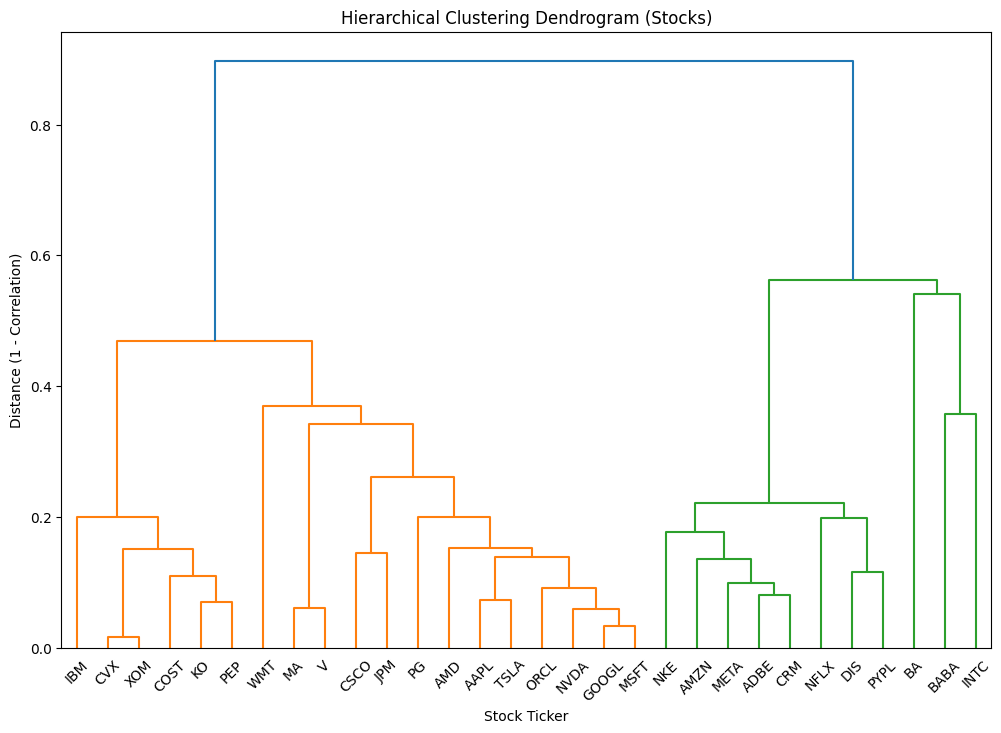

Best Unique Cointegrated Pairs:
Stock 1: IBM, Stock 2: XOM, p-value: 0.00714
Stock 1: BA, Stock 2: DIS, p-value: 0.00456


In [15]:
## Only get the unique best Pairs

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

def pearson_distance(u, v):
    """Calculate Pearson distance between two series."""
    return 1 - np.corrcoef(u, v)[0, 1]

def hierarchical_clustering_with_cointegration(tickers, start_date, end_date, distance_threshold=0.6, p_value_threshold=0.1):
    """
    Fetch historical stock data, perform hierarchical clustering using Pearson distance,
    and apply cointegration tests within each cluster to find pairs for pairs trading.
    Each stock will only be paired once with the best possible pair.

    Parameters:
    tickers (list): List of stock tickers to analyze.
    start_date (str): Start date for historical data.
    end_date (str): End date for historical data.
    distance_threshold (float): Threshold for forming flat clusters.
    p_value_threshold (float): Maximum p-value for considering a pair as cointegrated.

    Returns:
    final_pairs (list): List of tuples containing unique cointegrated pairs of stocks.
    """

    # Download stock data
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

    # Drop any columns with missing data
    data = data.dropna(axis=1, how='any')
    tickers = data.columns.tolist()  # Update tickers list based on available data

    # Transpose data for clustering
    data_transposed = data.T

    # Compute the Pearson distance matrix
    distance_matrix = pdist(data_transposed, metric=pearson_distance)

    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='average')

    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=data_transposed.index)
    plt.title('Hierarchical Clustering Dendrogram (Stocks)')
    plt.xlabel('Stock Ticker')
    plt.ylabel('Distance (1 - Correlation)')
    plt.show()

    # Form clusters based on the distance threshold
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

    # Assign cluster labels to stocks
    cluster_df = pd.DataFrame({'Ticker': data_transposed.index, 'Cluster': cluster_labels})

    # Apply cointegration tests within each cluster
    final_pairs = []
    used_stocks = set()  # Keep track of stocks that have already been paired

    for cluster_num in np.unique(cluster_labels):
        cluster_stocks = cluster_df[cluster_df['Cluster'] == cluster_num]['Ticker'].tolist()

        if len(cluster_stocks) < 2:
            continue  # Need at least two stocks to form a pair

        # Get all possible pairs
        pairs_in_cluster = []
        for i in range(len(cluster_stocks)):
            for j in range(i + 1, len(cluster_stocks)):
                stock1 = cluster_stocks[i]
                stock2 = cluster_stocks[j]

                # Skip if either stock has already been paired
                if stock1 in used_stocks or stock2 in used_stocks:
                    continue

                # Apply cointegration test on price series
                try:
                    score, p_value, _ = coint(data[stock1], data[stock2])
                    if p_value < p_value_threshold and not np.isnan(p_value):
                        pairs_in_cluster.append((stock1, stock2, p_value))
                except Exception as e:
                    print(f"Error testing pair {stock1} and {stock2}: {e}")

        # Sort pairs by p-value (best cointegration comes first)
        pairs_in_cluster.sort(key=lambda x: x[2])

        # Add the best pair(s) from the cluster, ensuring each stock is only used once
        for stock1, stock2, p_value in pairs_in_cluster:
            if stock1 not in used_stocks and stock2 not in used_stocks:
                final_pairs.append((stock1, stock2, p_value))
                used_stocks.update([stock1, stock2])  # Mark both stocks as used
                break  # Move on to the next cluster after finding the best pair

    return final_pairs

# Example usage
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 'BABA', 'JPM',
           'V', 'MA', 'PYPL', 'INTC', 'CSCO', 'ADBE', 'ORCL', 'IBM', 'AMD', 'CRM',
           'BA', 'COST', 'WMT', 'PG', 'KO', 'PEP', 'XOM', 'CVX', 'DIS', 'NKE']

pairs = hierarchical_clustering_with_cointegration(tickers, start_date="2020-01-01", end_date="2023-01-01",
                                                   distance_threshold=0.6, p_value_threshold=0.1)

# Print cointegrated pairs
print("Best Unique Cointegrated Pairs:")
for pair in pairs:
    print(f"Stock 1: {pair[0]}, Stock 2: {pair[1]}, p-value: {pair[2]:.5f}")
